In [2]:
import pandas as pd
import numpy as np
import lifelines
from patsy import dmatrix
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
import matplotlib.cm as cm  
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
df_train = pd.read_csv('df_train_cph4.csv')
df_test = pd.read_csv('df_test_cph4.csv') 

In [4]:
# CPH5

In [5]:
df_train_cph5 = df_train.copy()
df_test_cph5 = df_test.copy()

In [6]:
standardize = ['BMICALC',  'HRSLEEP']

normalize = ['AGE','POVERTY','ALCAMT', 'ALCDAYSYR', 'MOD10DMIN', 'MOD10FWK',
             'VIG10DMIN', 'STRONGFWK', 'AEFFORT', 'AFEELINT1MO', 'WRYRET',
             'AGE_CANCEREV', 'AGE_KIDNEYWKYR', 'CIGSDAY_EMPHYSEMEV',]

binary = ['SEX', 'USBORN', 'HINOTCOVE', 'HIMCAIDE', 'HIMCAREE',
          'BLIND', 'CANCEREV', 'CHEARTDIEV', 'CPOXEV', 'DIABETICEV', 'EMPHYSEMEV', 
          'HEARTATTEV', 'HEARTCONEV', 'KIDNEYWKYR', 'LIVERCHRON', 'LIVERCONYR', 'STROKEV',
          'RACEA_2', 'MARST_20', 'MARST_30', 'MARST_40', 'MARST_50', 'HSTATYR_2', 'HSTATYR_3',
          'SMOKESTATUS2_20', 'SMOKESTATUS2_30', 'ALCSTAT1_3', 'CANCEREV_STROKEV',
          'CANCEREV_HYPERTENEV', 'STROKEV_HEARTATTEV', 'LIVERCHRON_HEARTATTEV',
          'HYPERTENEV_STRONGFWK', 'HINOTCOVE_CANCEREV', 'FEMALE_MARST10','FEMALE_HYPERTENEV']

In [7]:
# standardize
scaler_standardize = StandardScaler()
df_train_cph5[standardize] = scaler_standardize.fit_transform(df_train_cph5[standardize])
df_test_cph5[standardize] = scaler_standardize.transform(df_test_cph5[standardize])

# normalize 
scaler_normalize = MinMaxScaler()
df_train_cph5[normalize] = scaler_normalize.fit_transform(df_train_cph5[normalize])
df_test_cph5[normalize] = scaler_normalize.transform(df_test_cph5[normalize])

# convert binary features to 0/1 
df_train_cph5[binary] = scaler_normalize.fit_transform(df_train_cph5[binary])
df_test_cph5[binary] = scaler_normalize.transform(df_test_cph5[binary])

In [8]:
# L2

In [9]:
penalties_2 = [0, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]

status_3y_train = np.where((df_train_cph5["MORTSTAT"] == 1) & (df_train_cph5["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test = np.where((df_test_cph5["MORTSTAT"] == 1) & (df_test_cph5["TIMETOEVENT"] <= 3), 0, 1)

formula="bs(BMICALC, degree=2, df=3) + bs(HRSLEEP, degree=1, df=2) + bs(STRONGFWK, degree=2, df=2) + bs(ALCDAYSYR, degree=1, df=2) + bs(ALCAMT, degree=2, df=2) + bs(POVERTY, degree=2, df=2) +" + " + ".join(df_train_cph5.columns.difference(['TIMETOEVENT', 'MORTSTAT','BMICALC', 'HRSLEEP', 'STRONGFWK', 'ALCDAYSYR', 'ALCAMT', 'POVERTY']))

apll_is = []
apll_os = []
c_index_is = []
c_index_os = []
ll3y_is = []
ll3y_os = []
bs_is = []
bs_os = []

for penalty in penalties_2:
    cph = CoxPHFitter(penalizer=penalty)  
    cph.fit(df_train_cph5, duration_col='TIMETOEVENT', event_col='MORTSTAT', formula=formula)

    apll_is.append(cph.score(df_train_cph5, scoring_method="log_likelihood"))
    apll_os.append(cph.score(df_test_cph5, scoring_method="log_likelihood"))
    c_index_is.append(cph.score(df_train_cph5, scoring_method="concordance_index"))
    c_index_os.append(cph.score(df_test_cph5, scoring_method="concordance_index"))
    
    # predict the survival function for each individual
    survival_probs_16_train = cph.predict_survival_function(df_train_cph5)
    survival_probs_16_test = cph.predict_survival_function(df_test_cph5)
    # extract 3y survival probabilities
    survival_prob_3y_train = survival_probs_16_train.iloc[3] 
    survival_prob_3y_test = survival_probs_16_test.iloc[3] 

    ll3y_is.append(log_loss(status_3y_train, survival_prob_3y_train))
    ll3y_os.append(log_loss(status_3y_test, survival_prob_3y_test))
    
    bs_is.append(brier_score_loss(status_3y_train, survival_prob_3y_train))
    bs_os.append(brier_score_loss(status_3y_test, survival_prob_3y_test))

In [10]:
colors_b = cm.Blues(np.linspace(0.3, 1, 10))
colors_g = cm.Greens(np.linspace(0.3, 1, 10))

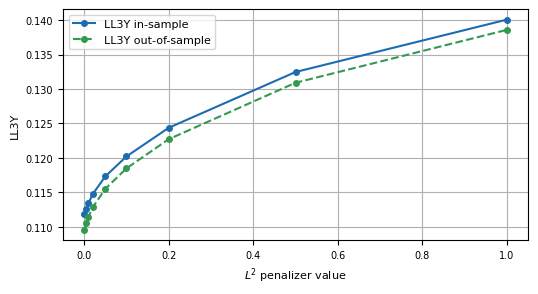

In [11]:
plt.figure(figsize=(6, 3))

plt.plot(penalties_2, ll3y_is, marker='o', markersize=4,  linestyle='-', label="LL3Y in-sample", color=colors_b[6])
plt.plot(penalties_2, ll3y_os, marker='o', markersize=4, linestyle='--', label="LL3Y out-of-sample", color=colors_g[5])

plt.xlabel(r"$L^2$ penalizer value", fontsize=8)
plt.ylabel("LL3Y", fontsize=8)
plt.legend(fontsize=8)
plt.grid()
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('ll3y_penalized.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

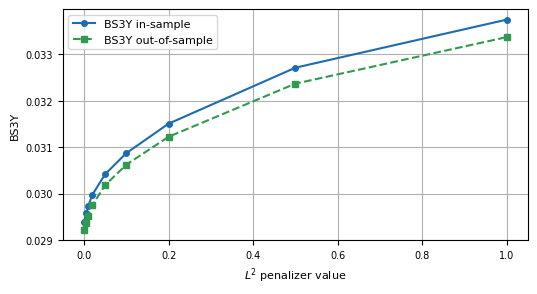

In [12]:
plt.figure(figsize=(6, 3))

plt.plot(penalties_2, bs_is, marker='o', linestyle='-', markersize=4, label="BS3Y in-sample", color=colors_b[6])
plt.plot(penalties_2, bs_os, marker='s', linestyle='--', markersize=4, label="BS3Y out-of-sample", color=colors_g[5])

plt.xlabel(r"$L^2$ penalizer value", fontsize=8)
plt.ylabel("BS3Y", fontsize=8)
plt.legend(fontsize=8)
plt.grid()
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('bs3y_penalized.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

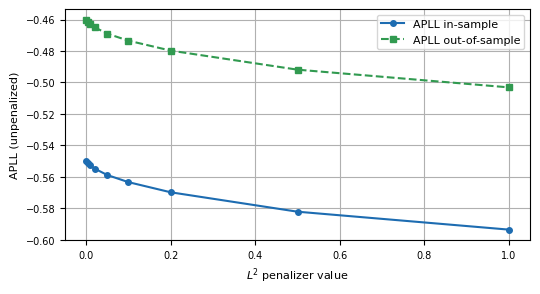

In [13]:
plt.figure(figsize=(6, 3))

plt.plot(penalties_2, apll_is, marker='o', linestyle='-', markersize=4, label="APLL in-sample", color=colors_b[6])
plt.plot(penalties_2, apll_os, marker='s', linestyle='--', markersize=4, label="APLL out-of-sample", color=colors_g[5])

plt.xlabel(r"$L^2$ penalizer value", fontsize=8)
plt.ylabel("APLL (unpenalized)", fontsize=8)
plt.legend(fontsize=8)
plt.grid()
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('apll_penalized.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

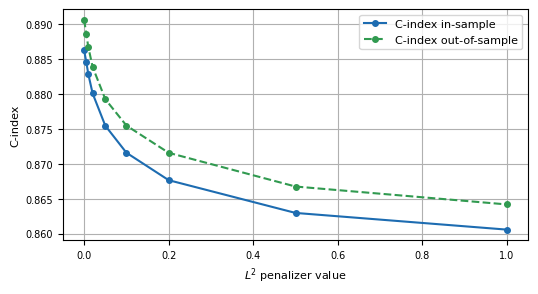

In [14]:
plt.figure(figsize=(6, 3))

plt.plot(penalties_2, c_index_is, marker='o', linestyle='-', markersize=4, label="C-index in-sample", color=colors_b[6])
plt.plot(penalties_2, c_index_os, marker='o', linestyle='--',markersize=4,  label="C-index out-of-sample", color=colors_g[5])

plt.xlabel(r"$L^2$ penalizer value", fontsize=8)
plt.ylabel("C-index", fontsize=8)
plt.legend(fontsize=8)
plt.grid()
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('c_penalized.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# l1

In [16]:
penalties_1 = [0, 0.0005,  0.001, 0.02, 0.05, 0.1, 0.2, 0.5]

status_3y_train = np.where((df_train_cph5["MORTSTAT"] == 1) & (df_train_cph5["TIMETOEVENT"] <= 3), 0, 1)
status_3y_test = np.where((df_test_cph5["MORTSTAT"] == 1) & (df_test_cph5["TIMETOEVENT"] <= 3), 0, 1)

apll_is = []
apll_os = []
c_index_is = []
c_index_os = []
ll3y_is = []
ll3y_os = []
bs_is = []
bs_os = []

for penalty in penalties_1:
    #print(penalty)
    cph = CoxPHFitter(penalizer=penalty, l1_ratio=1)  
    cph.fit(df_train_cph5, duration_col='TIMETOEVENT', event_col='MORTSTAT', formula=formula)

    apll_is.append(cph.score(df_train_cph5, scoring_method="log_likelihood"))
    apll_os.append(cph.score(df_test_cph5, scoring_method="log_likelihood"))
    c_index_is.append(cph.score(df_train_cph5, scoring_method="concordance_index"))
    c_index_os.append(cph.score(df_test_cph5, scoring_method="concordance_index"))
    
    # predict the survival function for each individual
    survival_probs_16_train = cph.predict_survival_function(df_train_cph5)
    survival_probs_16_test = cph.predict_survival_function(df_test_cph5)
    # extract 3y survival probabilities
    survival_prob_3y_train = survival_probs_16_train.iloc[3] 
    survival_prob_3y_test = survival_probs_16_test.iloc[3] 

    ll3y_is.append(log_loss(status_3y_train, survival_prob_3y_train))
    ll3y_os.append(log_loss(status_3y_test, survival_prob_3y_test))
    
    bs_is.append(brier_score_loss(status_3y_train, survival_prob_3y_train))
    bs_os.append(brier_score_loss(status_3y_test, survival_prob_3y_test))

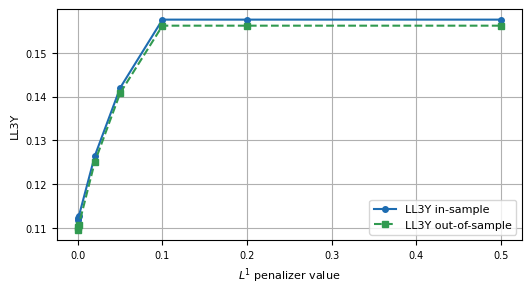

In [17]:
plt.figure(figsize=(6, 3))

plt.plot(penalties_1, ll3y_is, marker='o', markersize=4,  linestyle='-', label="LL3Y in-sample", color=colors_b[6])
plt.plot(penalties_1, ll3y_os, marker='s', markersize=4, linestyle='--', label="LL3Y out-of-sample", color=colors_g[5])

plt.xlabel(fr"$L^1$ penalizer value ", fontsize=8)
plt.ylabel("LL3Y", fontsize=8)
plt.legend(fontsize=8)
plt.grid()
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('ll3y_penalized_l1.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

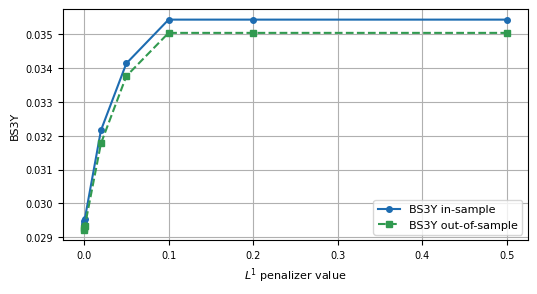

In [18]:
plt.figure(figsize=(6, 3))

plt.plot(penalties_1, bs_is, marker='o', markersize=4, linestyle='-', label="BS3Y in-sample", color=colors_b[6])
plt.plot(penalties_1, bs_os, marker='s', markersize=4, linestyle='--', label="BS3Y out-of-sample", color=colors_g[5])

plt.xlabel(fr"$L^1$ penalizer value", fontsize=8)
plt.ylabel("BS3Y", fontsize=8)
plt.legend(fontsize=8)
plt.grid()
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('bs3y_penalized_l1.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

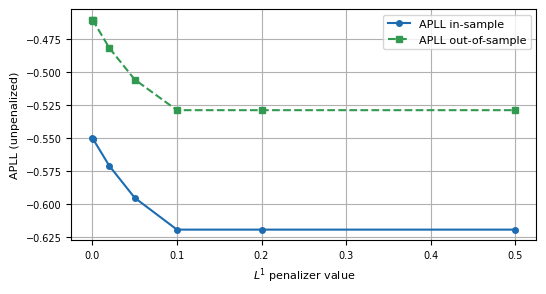

In [19]:
plt.figure(figsize=(6, 3))

plt.plot(penalties_1, apll_is, marker='o', markersize=4, linestyle='-', label="APLL in-sample", color=colors_b[6])
plt.plot(penalties_1, apll_os, marker='s', markersize=4, linestyle='--', label="APLL out-of-sample", color=colors_g[5])

plt.xlabel(fr"$L^1$ penalizer value", fontsize=8)
plt.ylabel("APLL (unpenalized)", fontsize=8)
plt.legend(fontsize=8)
plt.grid()
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('apll_penalized_l1.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

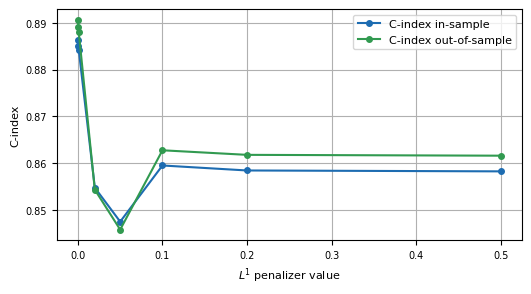

In [20]:
plt.figure(figsize=(6, 3))

plt.plot(penalties_1, c_index_is, marker='o', markersize=4, linestyle='-', label="C-index in-sample", color=colors_b[6])
plt.plot(penalties_1, c_index_os, marker='o', markersize=4, linestyle='-', label="C-index out-of-sample", color=colors_g[5])

plt.xlabel(fr"$L^1$ penalizer value", fontsize=8)
plt.ylabel("C-index", fontsize=8)
plt.legend(fontsize=8)
plt.grid()
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('c_penalized_l1.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# mix

In [22]:
penalties_1 = [0, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
l1_ratios = [0, 0.2, 0.5, 0.8, 1]  
results = []

for l1_ratio in l1_ratios:
    for penalty in penalties_1:
        # fit 
        cph = CoxPHFitter(penalizer=penalty, l1_ratio=l1_ratio)
        cph.fit(df_train_cph5, duration_col='TIMETOEVENT', event_col='MORTSTAT', formula=formula)

        # compute scores
        apll_is = cph.score(df_train_cph5, scoring_method="log_likelihood")
        apll_os = cph.score(df_test_cph5, scoring_method="log_likelihood")
        c_index_is = cph.score(df_train_cph5, scoring_method="concordance_index")
        c_index_os = cph.score(df_test_cph5, scoring_method="concordance_index")

        # compute 3-year survival probability metrics
        survival_probs_3y_train = cph.predict_survival_function(df_train_cph5).iloc[3]
        survival_probs_3y_test = cph.predict_survival_function(df_test_cph5).iloc[3]

        ll3y_is = log_loss(status_3y_train, survival_probs_3y_train)
        ll3y_os = log_loss(status_3y_test, survival_probs_3y_test)
        bs_is = brier_score_loss(status_3y_train, survival_probs_3y_train)
        bs_os = brier_score_loss(status_3y_test, survival_probs_3y_test)

        # store results in list
        results.append({
            "penalty": penalty,
            "l1_ratio": l1_ratio,
            "APLL_is": apll_is,
            "APLL_os": apll_os,
            "C_index_is": c_index_is,
            "C_index_os": c_index_os,
            "LL3Y_is": ll3y_is,
            "LL3Y_os": ll3y_os,
            "BS3Y_is": bs_is,
            "BS3Y_os": bs_os
        })

# convert results to df
results_df = pd.DataFrame(results)

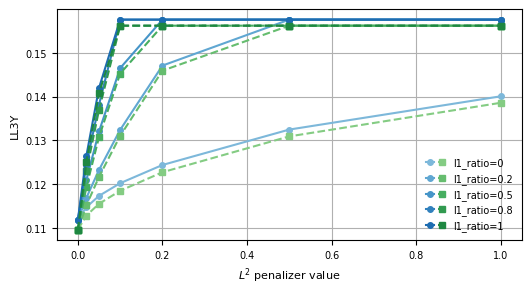

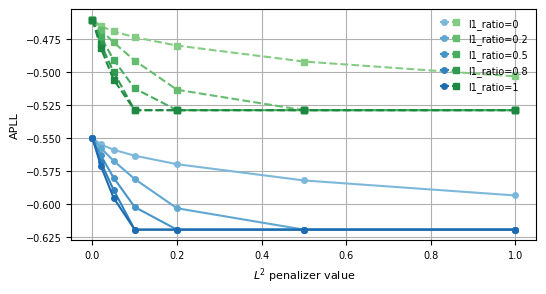

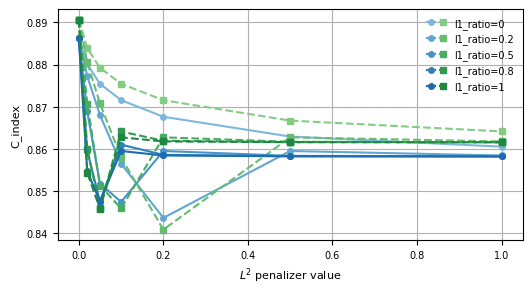

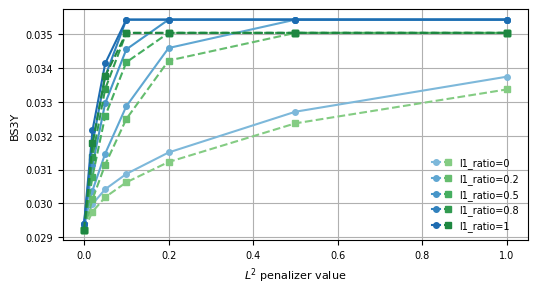

In [23]:
metrics = ["LL3Y", "APLL", "C_index", "BS3Y"]  

for metric in metrics:
    plt.figure(figsize=(6, 3))
    
    legend_handles = []  
    
    for i, l1_ratio in enumerate(l1_ratios):
        subset = results_df[results_df["l1_ratio"] == l1_ratio]  

        # plot in-sample with blue shades
        line1, = plt.plot(
            subset["penalty"], subset[f"{metric}_is"], 
            marker='o', markersize=4, linestyle='-', color=colors_b[i+2])

        # plot out-of-sample with red shades
        line2, = plt.plot(
            subset["penalty"], subset[f"{metric}_os"], 
            marker='s', markersize=4, linestyle='--', color=colors_g[i+2])

        # add legend entry with both colors
        legend_handles.append((line1, line2))


    plt.xlabel(r"$L^2$ penalizer value", fontsize=8)
    plt.ylabel(metric, fontsize=8)
    plt.legend(
        legend_handles, [f"l1_ratio={l1_ratio}" for l1_ratio in l1_ratios],
        fontsize=7, loc="best", frameon=False, handler_map={tuple: plt.matplotlib.legend_handler.HandlerTuple(None)})
    
    plt.grid()
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.savefig(f'{metric}_mix.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

In [24]:
# save for next model (nothing changed -  we do not proceed with standardize/ noramlized df)
df_train_cph5.to_csv("df_train.csv", index=False)
df_test_cph5.to_csv("df_test.csv", index=False)